<h2>Imports</h2>

In [92]:
""" 

based on example coded provided in Foster, 2019 see:

basic GAN
"G:\Dev\DataScience\GDL_code\models\GAN.py"

Wasserstein GAN
"G:\Dev\DataScience\GDL_code\models\WGAN.py"

Wasserstein GAN with Gradient Penatly
"G:\Dev\DataScience\GDL_code\models\WGANGP.py"

"""
# imports
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.experimental import preprocessing
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras.losses import binary_crossentropy

import numpy as np
import os
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import pathlib
import tensorflow as tf

print(tf.__version__)

2.3.0


<h2>Data Load</h2>

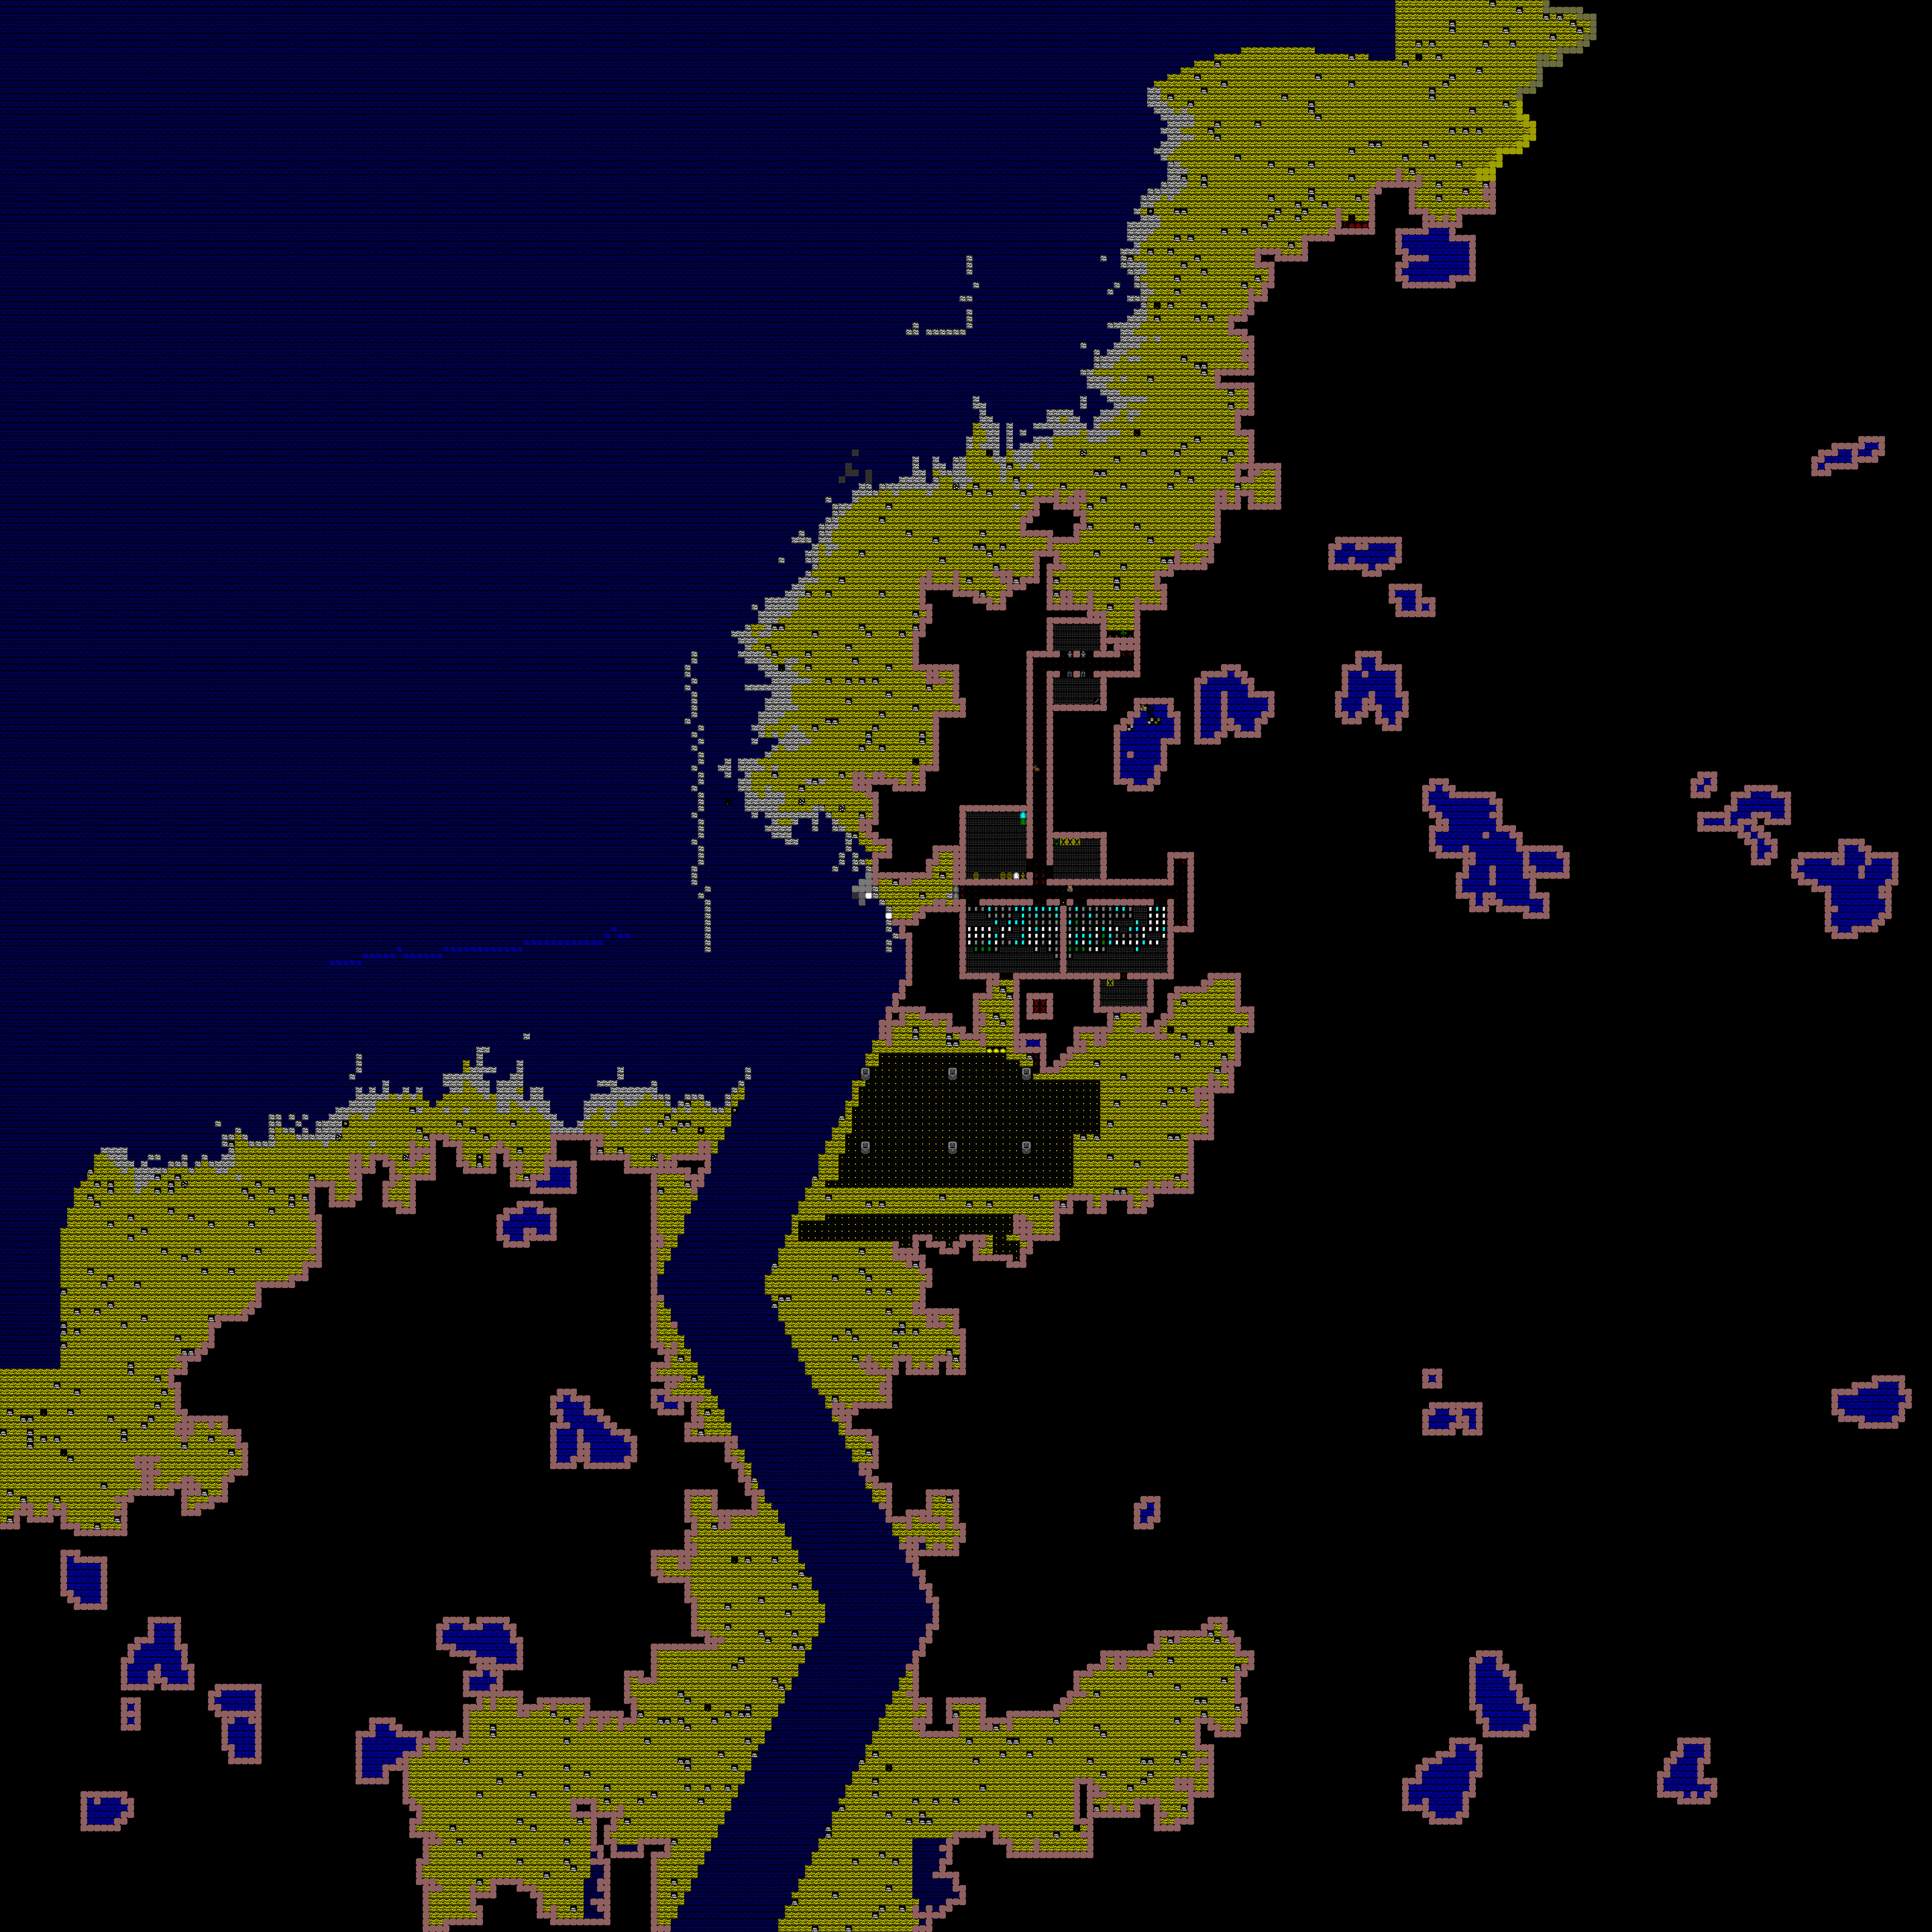

In [437]:
# NOTE: so far, only all .fdf-map archives with first letter X, Y or Z have been extracted, and map archives which only contained 1 picture (these were already exported as a single picture, not an archive)
fpath = r'G:\Dev\DataScience\masterthesis_gan_mapdesign\data\Dwarf Fortress Maps'
data_dir = pathlib.Path(fpath + '\PNG Exports')
imgs = list(data_dir.glob('*.png'))

# Visualize random image
PIL.Image.open(imgs[np.random.randint(0, len(imgs))])


<h3>Train / Validation Split</h3>

In [438]:
len(imgs)

3652

In [439]:
# creating keras datasets for training and validation
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(  fpath,
                                                                      image_size=(1024,1024), # rescaling here already? --> default 256x256
                                                                      batch_size=64, 
                                                                      labels=[1] * len(imgs), # setting all labels to 1 (for 'real')
                                                                      #label_mode=None, # yields float32 type labels
                                                                      seed=42,
                                                                      validation_split=0.1,
                                                                      subset='training'
                                                                    )

dataset_val = tf.keras.preprocessing.image_dataset_from_directory(  fpath,
                                                                    image_size=(1024,1024), # rescaling here already? --> default 256x256
                                                                    batch_size=64, 
                                                                    labels=[1] * len(imgs), # setting all labels to 1 (for 'real')
                                                                    #label_mode=None, # yields float32 type labels
                                                                    seed=42,
                                                                    validation_split=0.1,
                                                                    subset='validation'
                                                                    )


Found 3652 files belonging to 1 classes.
Using 3287 files for training.
Found 3652 files belonging to 1 classes.
Using 365 files for validation.


<h3>Check Random Samples</h3>

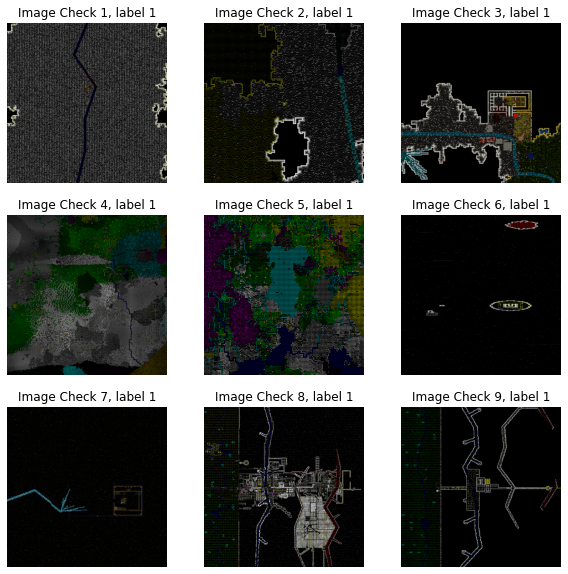

In [278]:
# Check random images
plt.figure(figsize=(10, 10))
for images, labels in dataset_train.take(1): # take one batch. Here batch_size = 32 examples per batch
    for i in range(9): # show first 9 iumages of batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Image Check {i+1}, label {labels[i]}')
        plt.axis('off')

<h3>Enabling Buffering / Prefetching</h3>

In [440]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = dataset_val.cache().prefetch(buffer_size=AUTOTUNE)

<h2>Discriminator Definition</h2>

In [415]:
# set input variables to variable widht + height. Will be resized in preprocessing
input_dim = (None, None, 3)

# Input
d_input = Input(shape=input_dim, name='Discriminator_Input')

# Keras-based preprocessing. Alternative: RandomCrop()
# use smart_resizing?
#x = tf.keras.preprocessing.image.smart_resize(d_input, (1024, 1024))
x = preprocessing.Resizing(width=1024, 
                           height=1024, 
                           name='Preprocessing_Resize'
                          )(d_input) # Resize to 1024 x 1024 images

x = preprocessing.Rescaling(scale=1./255, 
                            offset=-1,
                            name='Preprocessing_Rescale'
                           )(x) # Rescale values from 0-255 to -1-1


# Conv2D Layer 1
x = Conv2D(
        filters = 128,
        kernel_size = 5,
        strides = 2,
        padding = 'same',
        name = 'Discriminator_Conv2D_Layer_1'
)(x)

# BatchNorm Layer 1
x = BatchNormalization()(x)

# Activation 1 - Leaky ReLU
x = LeakyReLU(alpha = 0.1, name='Activation_1')(x)

# Dropout 1
x = Dropout(rate = 0.4)(x)


# Conv2D Layer 2
x = Conv2D(
        filters = 128,
        kernel_size = 5,
        strides = 2,
        padding = 'same',
        name = 'Discriminator_Conv2D_Layer_2',
        kernel_initializer = RandomNormal(mean=0., stddev=0.02)
)(x)

# BatchNorm Layer 2
x = BatchNormalization()(x)

# Activation 2 - Leaky ReLU
x = LeakyReLU(alpha = 0.1, name='Activation_2')(x)

# Dropout 2
x = Dropout(rate = 0.4)(x)


# Conv2D Layer 3
x = Conv2D(
        filters = 128,
        kernel_size = 5,
        strides = 2,
        padding = 'same',
        name = 'Discriminator_Conv2D_Layer_3',
        kernel_initializer = RandomNormal(mean=0., stddev=0.02)
)(x)

# BatchNorm Layer 3
x = BatchNormalization()(x)

# Activation 3 - Leaky ReLU
x = LeakyReLU(alpha = 0.1, name='Activation_3')(x)

# Dropout 3
x = Dropout(rate = 0.4)(x)



# Conv2D Layer 4
x = Conv2D(filters = 128,
           kernel_size = 5,
           strides = 2,
           padding = 'same',
           name = 'Discriminator_Conv2D_Layer_4',
           kernel_initializer = RandomNormal(mean=0., stddev=0.02)
)(x)

# BatchNorm Layer 4
x = BatchNormalization()(x)

# Activation 4 - Leaky ReLU
x = LeakyReLU(alpha = 0.1, name='Activation_4')(x)

# Dropout 4
x = Dropout(rate = 0.4)(x)




# Conv2D Layer 5
x = Conv2D(filters = 64,
           kernel_size = 5,
           strides = 2,
           padding = 'same',
           name = 'Discriminator_Conv2D_Layer_5',
           kernel_initializer = RandomNormal(mean=0., stddev=0.02)
)(x)

# BatchNorm Layer 5
x = BatchNormalization()(x)

# Activation 5 - Leaky ReLU
x = LeakyReLU(alpha = 0.1, name='Activation_5')(x)

# Dropout 5
x = Dropout(rate = 0.4)(x)


# OUTPUT
x = Flatten()(x)
d_output = Dense(1, 
                 activation='sigmoid', 
                 kernel_initializer = RandomNormal(mean=0, stddev=0.02) # random initialization of weights with normal distribution around 0 with small SD
                )(x)



# Model intialization
discriminator = Model(d_input, d_output, name='Discriminator')


In [83]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Discriminator_Input (InputLa [(None, None, None, 3)]   0         
_________________________________________________________________
Preprocessing_Resize (Resizi (None, 1024, 1024, 3)     0         
_________________________________________________________________
Preprocessing_Rescale (Resca (None, 1024, 1024, 3)     0         
_________________________________________________________________
Discriminator_Conv2D_Layer_1 (None, 512, 512, 128)     9728      
_________________________________________________________________
batch_normalization_40 (Batc (None, 512, 512, 128)     512       
_________________________________________________________________
Activation_1 (LeakyReLU)     (None, 512, 512, 128)     0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 512, 512, 128)   

<h2>Generator Definition</h2>

In [120]:
# set input variable dimensions. Here we will start out with a vector of length 100 for each sample (sampled from a normal distribution, representing the learned latent space)
input_dim = (100)

# Input
g_input = Input(shape=input_dim, name='Generator_Input')

# Dense Layer 1
x = Dense(np.prod([16,16,32]))(g_input)

# Batch Norm Layer 1
x = BatchNormalization(momentum = 0.9)(x)

# Activation Layer 1
x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

# Reshape into 3D tensor
x = Reshape((16,16,32))(x)

# Upsampling Layer 1 + Conv2D Layer1
x = UpSampling2D()(x)
x = Conv2D(filters=64, kernel_size=5, padding='same', name='Generator_Conv_Layer_1')(x)

# Batch Norm Layer 2
x = BatchNormalization(momentum = 0.9)(x)

# Activation Layer 2
x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

# Upsampling Layer 2 + Conv2D Layer2
x = UpSampling2D()(x)
x = Conv2D(filters=128, kernel_size=5, padding='same', name='Generator_Conv_Layer_2')(x)


# Batch Norm Layer 3
x = BatchNormalization(momentum = 0.9)(x)

# Activation Layer 3
x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

# Upsampling Layer 3 + Conv2D Layer3
x = UpSampling2D()(x)
x = Conv2D(filters=64, kernel_size=5, padding='same', name='Generator_Conv_Layer_3')(x)


# Batch Norm Layer 4
x = BatchNormalization(momentum = 0.9)(x)

# Activation Layer 4
x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

# Upsampling Layer 4 + Conv2D Layer4
x = UpSampling2D()(x)
x = Conv2D(filters=64, kernel_size=5, padding='same', name='Generator_Conv_Layer_4')(x)


# Batch Norm Layer 5
x = BatchNormalization(momentum = 0.9)(x)

# Activation Layer 5
x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)



# Upsampling Layer 5 + Conv2D Layer5
x = UpSampling2D()(x)
x = Conv2D(filters=32, kernel_size=5, padding='same', name='Generator_Conv_Layer_5')(x)


# Batch Norm Layer 6
x = BatchNormalization(momentum = 0.9)(x)

# Activation Layer 6
x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)

# Upsampling Layer 7 + Conv2D Layer7
x = UpSampling2D()(x)
x = Conv2D(filters=32, kernel_size=5, padding='same', name='Generator_Conv_Layer_6')(x)


# Batch Norm Layer 7
x = BatchNormalization(momentum = 0.9)(x)

# Activation Layer 7
x = LeakyReLU()(x) # trying leaky ReLU instead of Activation('relu')(x)


# Upsampling Layer 8 + Conv2D Layer8
x = Conv2D(filters=3, kernel_size=5, padding='same', name='Generator_Conv_Layer_7')(x)

# tanh activation layer to scale values to [-1:1]
x = Activation('tanh')(x)

# Output
g_output = x

# Model initialization
generator = Model(g_input, g_output, name='Generator')

generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator_Input (InputLayer) [(None, 100)]             0         
_________________________________________________________________
dense_34 (Dense)             (None, 8192)              827392    
_________________________________________________________________
batch_normalization_79 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 16, 16, 32)        0         
_________________________________________________________________
up_sampling2d_25 (UpSampling (None, 32, 32, 32)        0         
_________________________________________________________________
Generator_Conv_Layer_1 (Conv (None, 32, 32, 64)        51

<h2>Compilation and Training</h2>

<h3>Discriminator Compilation</h3>

In [416]:
discriminator.compile(optimizer=Adam(lr=0.0008), # per Foster, 2017 RMSprop(lr=0.0008)
                      loss=binary_crossentropy, 
                      metrics=['accuracy']) 


<h3>Generator Compilation</h3>

In [417]:
# to train the generator as part of the full GAN, we have to freeze the discriminator weights
discriminator.trainable = False

model_input = Input(shape=(100), name='GAN_input')
# Output of generator is connected to the discriminator here
model_output = discriminator(generator(model_input))

# The complete GAN model
gan = Model(model_input, model_output)

gan.compile(optimizer=RMSprop(lr=0.0004), # here we try RMSprop instead of ADAM with a learning rate of 0.0004 (< than discriminator lr as the discriminator should be stronger than the generator)
            loss=binary_crossentropy, 
            metrics=['accuracy'])

<h3>Train Discriminator</h3 

In [331]:
def train_discriminator(x_train, batch_size):
    '''
    Train Discriminator on real and fake images
    '''
    
    #make sure discriminator is trainable
    discriminator.trainable = True
    
    #iterate over pre-made batches
    for images, labels in x_train.take(1):
        #Real Images
        discriminator.train_on_batch(images, labels)

        #Generated Images
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise) # random generated images of (untrained) generator
        discriminator.train_on_batch(gen_imgs, np.ones((batch_size, 1)))
    
def train_generator(batch_size):
    '''
    Train Generator on random generated 100 dimensional input vector
    '''
    
    #make sure the discriminator is NOT trainable for the generator/full GAN training
    discriminator.trainable = False
    
    #train generator/GAN
    noise = np.random.normal(0, 1, (batch_size, 100))
    gan.train_on_batch(noise, np.zeros((batch_size,1)))
    
    
def train_gan(disc_train, epoches, batch_size):
    '''
    Train the complete GAN by iterating over the number of epoches
    and alternate between training the discriminator and generator
    '''
    for i in range(epoches):
        print(f"[{10*'-'}] GAN Epoche {i+1} started [{10*'-'}]")
        train_discriminator(disc_train, batch_size)
        train_generator(batch_size)

In [326]:
# Debug
for images, labels in dataset_train.take(1):
    print(images.shape, type(images))
    print(labels.shape, type(labels))
    (images, labels)


(32, 1024, 1024, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
(32,) <class 'tensorflow.python.framework.ops.EagerTensor'>


TypeError: 'BatchDataset' object is not subscriptable

### Full Discriminator Training Test (Actual Images)

In [287]:
#valid = np.ones((193, 1)).astype('float32')
# non-batch for few examples
#discriminator.train_on_batch(tf.cast(dataset_train,tf.uint8), valid)
discriminator.trainable = True
discriminator.fit(train_ds, validation_data=val_ds, batch_size=64, epochs=10)

Epoch 1/10
7/7 [==============================] - 331s 47s/step - loss: 1.6820e-06 - accuracy: 1.0000 - val_loss: 0.1540 - val_accuracy: 1.0000
Epoch 2/10
7/7 [==============================] - 335s 48s/step - loss: 3.0061e-14 - accuracy: 1.0000 - val_loss: 0.0221 - val_accuracy: 1.0000
Epoch 3/10
7/7 [==============================] - 335s 48s/step - loss: 4.1643e-15 - accuracy: 1.0000 - val_loss: 5.1027e-04 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 339s 48s/step - loss: 7.9007e-16 - accuracy: 1.0000 - val_loss: 6.9678e-06 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 337s 48s/step - loss: 8.1498e-15 - accuracy: 1.0000 - val_loss: 1.0533e-07 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 323s 46s/step - loss: 4.0079e-16 - accuracy: 1.0000 - val_loss: 2.4683e-09 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 329s 47s/step - loss: 2.1887e-16 - accuracy: 1.0000 - val_loss: 8.9700

### GAN Training Test (Batched)

In [333]:
train_gan(train_ds, 10, 32)

[----------] GAN Epoche 1 started [----------]
[----------] GAN Epoche 2 started [----------]
[----------] GAN Epoche 3 started [----------]
[----------] GAN Epoche 4 started [----------]
[----------] GAN Epoche 5 started [----------]
[----------] GAN Epoche 6 started [----------]
[----------] GAN Epoche 7 started [----------]
[----------] GAN Epoche 8 started [----------]
[----------] GAN Epoche 9 started [----------]
[----------] GAN Epoche 10 started [----------]


### Check Generator Output (10 Epoches)

(-0.5, 1023.5, 1023.5, -0.5)

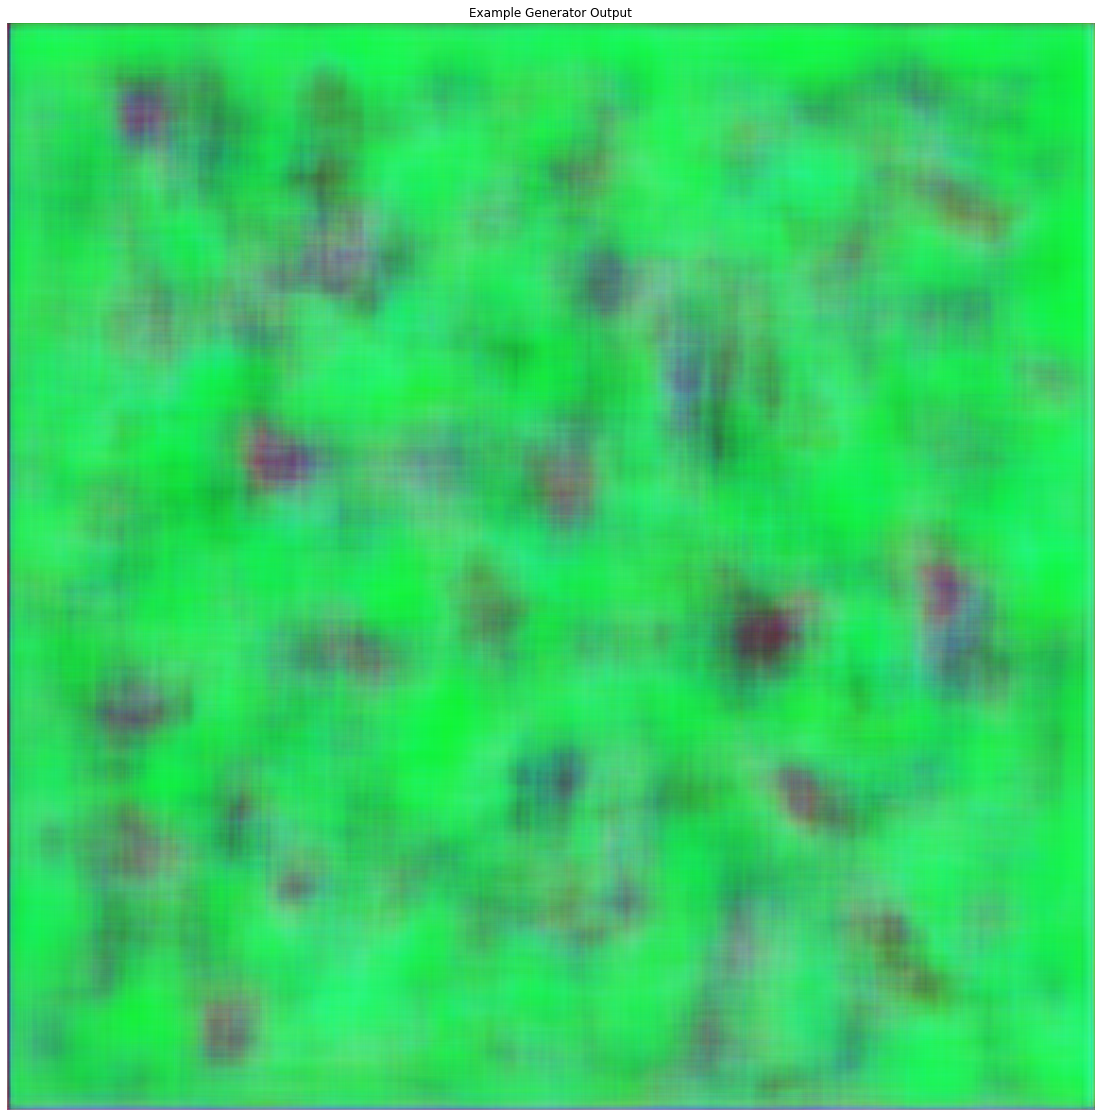

In [414]:
# generate new example of learned representation in latent space
noise = np.random.normal(0, 1, (1, 100))
res = generator.predict(noise)

# reinstate original scale of pixel values [1:255] and reshape
res = 0.5 * (res + 1)
res = res.reshape((1024, 1024, 3))

# Visualize result
plt.figure(figsize=(20, 20))
plt.imshow(res)
plt.title(f'Example Generator Output')
plt.axis('off')

### Train GAN on 100 epoches

In [442]:
train_gan(train_ds, 100, 32)

[----------] GAN Epoche 1 started [----------]
[----------] GAN Epoche 2 started [----------]
[----------] GAN Epoche 3 started [----------]
[----------] GAN Epoche 4 started [----------]
[----------] GAN Epoche 5 started [----------]
[----------] GAN Epoche 6 started [----------]
[----------] GAN Epoche 7 started [----------]
[----------] GAN Epoche 8 started [----------]
[----------] GAN Epoche 9 started [----------]
[----------] GAN Epoche 10 started [----------]
[----------] GAN Epoche 11 started [----------]
[----------] GAN Epoche 12 started [----------]
[----------] GAN Epoche 13 started [----------]
[----------] GAN Epoche 14 started [----------]
[----------] GAN Epoche 15 started [----------]
[----------] GAN Epoche 16 started [----------]
[----------] GAN Epoche 17 started [----------]
[----------] GAN Epoche 18 started [----------]
[----------] GAN Epoche 19 started [----------]
[----------] GAN Epoche 20 started [----------]
[----------] GAN Epoche 21 started [----------]
[

### Check Generator Output (100 Epoches)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../models/generator-100e\assets
INFO:tensorflow:Assets written to: ../models/full-gan-100e\assets


(-0.5, 1023.5, 1023.5, -0.5)

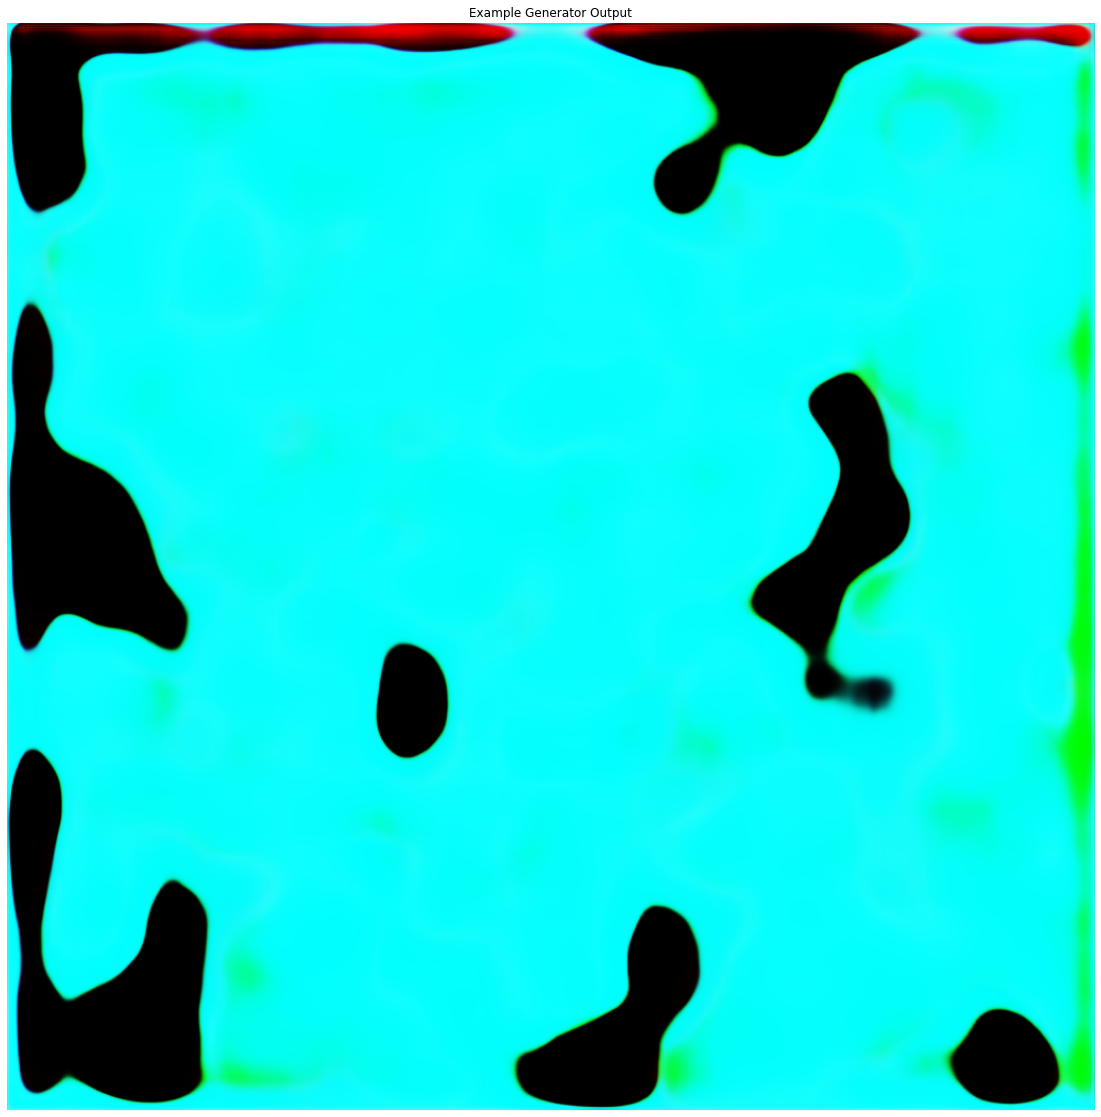

In [457]:
# saving (100 epoche) model
# generator
generator.save(r'../models/generator-100e')

# full model
gan.save(r'../models/full-gan-100e')
               
# generate new example of learned representation in latent space
noise = np.random.normal(0, 1, (1, 100))
res = generator.predict(noise)

# reinstate original scale of pixel values [1:255] and reshape
res = 0.5 * (res + 1)
res = res.reshape((1024, 1024, 3))

# Visualize result
plt.figure(figsize=(20, 20))
plt.imshow(res)
plt.title(f'Example Generator Output')
plt.axis('off')

### Changes made after 100 epoche run
- Batch size 32 --> 64
- Discriminator Optimizer Adam -> RMSprop
- Added discriminator.trainable = True/False flags to training functions for discriminator/generator (GAN) to ensure discriminator is actually trainable
- So far only 3652 images were used for training (single image maps and map archives starting with X, Y or Z). The next training cycle will include maps starting with U, V or W